## 1)  Lenet5 + cropping+ normalization + Data Augmenting 180-flipped images + 5-epochs

In [ ]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle

lines = []
i = 0
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if(i > 0): #this part is added to insure the 1st line in the csvfile which include the headers is not included
             lines.append(line)
        i = i + 1

# create adjusted steering measurements for the side camera images
correction = 0.01 # this is a parameter to tune

images = []
measurments = []
# use this section if you wanna use images from the 3-cameras
#for line in lines:
    #print(line)
 #   for i in range(3):
        # get the image path from the file
  #      source_path = line[i]
   #     filename = source_path.split('/')[-1]
    #    current_path = 'IMG/'+ filename
        #print('current_path', current_path)
     #   image = cv2.imread(current_path)
      #  images.append(image)
        # get the steering measurmement (labels) from the file
       # measurment = line[3]
        #if (i == 0):
         #   measurments.append(float(measurment))
        #if (i == 1):
         #    measurments.append(float(measurment) + correction)
        #if (i == 2):
         #    measurments.append(float(measurment) - correction)
            
            
  

# use this section if you wanna use only the central camera image
for line in lines:
    #print(line)
    # get the image path from the file
    source_path = line[0]
    filename = source_path.split('/')[-1]
    current_path = 'data/IMG/'+ filename
    #print('current_path', current_path)
    image = cv2.imread(current_path)
    images.append(image)
     # get the steering measurmement (labels) from the file
    measurment = line[3]
    measurments.append(float(measurment))
        
        
        
# convert features and labels to numpy array as that's the format keras requires  
print("Sample of labels", measurments[4823] )
#X_train = np.array(images)
#y_train = np.array(measurments) 
#print(X_train[0].shape, ' shape of train samples')
#print("size of training set", len(X_train))

from sklearn.utils import shuffle
# Shuffle training data, NOTE: No need for that part as it will be done in the model.fit()
#X_train, y_train = shuffle(X_train, y_train)

# Data Augmentation
augmented_images, augmented_measurments = [], []
for image,measurment in zip(images, measurments):
    augmented_images.append(image)
    augmented_measurments.append(measurment)
    augmented_images.append(cv2.flip(image, 1)) #flip image 180 horizontally
    augmented_measurments.append(measurment * -1.0) # reverse the steering angle
   



X_train = np.array(augmented_images)
y_train = np.array(augmented_measurments) 
# display sample image and it's corresponding label (steerng angle)
print(X_train[0].shape, ' shape of train samples')
#print(" a sample of label before flipping", y_train[4823])
#print(" a sample of label after  flipping", y_train[4824])
print("size of training set", len(X_train))

#print (" Subset y-labels are")
#print(y_train[0:1000])
    


# build a very simple model to test on it
import keras
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense  
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Lambda
from keras.layers import Cropping2D


model = Sequential()

# Preprocessing the data using Normalization and Mean-Center
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))

# Cropping un-useful details from the image to avoid distracting model training. Here I removed 50-pixels from top and 20 pixels from bottom.
model.add(Cropping2D(cropping=((70,25), (0,0))))

# Using LeNet5 model 
model.add(Convolution2D(6, 5, 5, activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(6, 5, 5, activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(84))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, validation_split=0.3, shuffle=True, epochs=5)

# save the model to reuse or download
model.save('model.h5')

# NOTE: by default Keras train for 10 epochs
# you will notice that before the 7th-epoch, the validation loss was decreasing then after it increased, so to prevent overfittng, we can nb_epoch = 7

print ('end')


## 2)  [NVIDIA](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) + cropping+ normalization + Data Augmenting 180-flipped images + 5-epochs or 3-epochs

In [ ]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle

lines = []
i = 0
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if(i > 0): #this part is added to insure the 1st line in the csvfile which include the headers is not included
             lines.append(line)
        i = i + 1

# create adjusted steering measurements for the side camera images
correction = 0.01 # this is a parameter to tune

images = []
measurments = []
# use this section if you wanna use images from the 3-cameras
#for line in lines:
    #print(line)
 #   for i in range(3):
        # get the image path from the file
  #      source_path = line[i]
   #     filename = source_path.split('/')[-1]
    #    current_path = 'IMG/'+ filename
        #print('current_path', current_path)
     #   image = cv2.imread(current_path)
      #  images.append(image)
        # get the steering measurmement (labels) from the file
       # measurment = line[3]
        #if (i == 0):
         #   measurments.append(float(measurment))
        #if (i == 1):
         #    measurments.append(float(measurment) + correction)
        #if (i == 2):
         #    measurments.append(float(measurment) - correction)
            
            
  

# use this section if you wanna use only the central camera image
for line in lines:
    #print(line)
    # get the image path from the file
    source_path = line[0]
    filename = source_path.split('/')[-1]
    current_path = 'data/IMG/'+ filename
    #print('current_path', current_path)
    image = cv2.imread(current_path)
    images.append(image)
     # get the steering measurmement (labels) from the file
    measurment = line[3]
    measurments.append(float(measurment))
        
        
        
# convert features and labels to numpy array as that's the format keras requires  
print("Sample of labels", measurments[4823] )
#X_train = np.array(images)
#y_train = np.array(measurments) 
#print(X_train[0].shape, ' shape of train samples')
#print("size of training set", len(X_train))

from sklearn.utils import shuffle
# Shuffle training data, NOTE: No need for that part as it will be done in the model.fit()
#X_train, y_train = shuffle(X_train, y_train)

# Data Augmentation
augmented_images, augmented_measurments = [], []
for image,measurment in zip(images, measurments):
    augmented_images.append(image)
    augmented_measurments.append(measurment)
    augmented_images.append(cv2.flip(image, 1)) #flip image 180 horizontally
    augmented_measurments.append(measurment * -1.0) # reverse the steering angle
   



X_train = np.array(augmented_images)
y_train = np.array(augmented_measurments) 
# display sample image and it's corresponding label (steerng angle)
print(X_train[0].shape, ' shape of train samples')
#print(" a sample of label before flipping", y_train[4823])
#print(" a sample of label after  flipping", y_train[4824])
print("size of training set", len(X_train))

#print (" Subset y-labels are")
#print(y_train[0:1000])
    


# build a very simple model to test on it
import keras
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense  
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Lambda
from keras.layers import Cropping2D
#from keras.utils.visualize_util import plot


model = Sequential()

# Preprocessing the data using Normalization and Mean-Center
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))

# Cropping un-useful details from the image to avoid distracting model training. Here I removed 50-pixels from top and 20 pixels from bottom.
model.add(Cropping2D(cropping=((70,25), (0,0))))

# Using NVIDIA model 
model.add(Conv2D(24, (5, 5), activation="relu", strides=(2, 2)))
#model.add(MaxPooling2D())
model.add(Conv2D(36, (5, 5), activation="relu", strides=(2, 2)))
#model.add(MaxPooling2D())
model.add(Conv2D(48, (5, 5), activation="relu", strides=(2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, validation_split=0.3, shuffle=True, epochs=3)
          


### print the keys contained in the history object
print(history.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()          

# save the model to reuse or download
model.save('model.h5')

# NOTE: by default Keras train for 10 epochs

# visualize model layout with pydot_ng
#plot(model, to_file='model.png', show_shapes=True)
print ('end')


## 3) [NVIDIA](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) + cropping+ normalization + Data Augmenting 180-flipped images +  5-epochs + Generators

In [1]:
# Importing all required libraries
import os
import time
import csv
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import sklearn
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Images resizing and pre-processing
def image_preprocess(img):
    
    # original Image shape is:  160x320x3 while input shape for the Nvidia model is:  66x200x3
    # crop to 40x320x3
    #n_img = img[50:140,0,0]
    n_img = cv2.GaussianBlur(img, (3,3), 0)
    # scale to 66x200x3 (same as nVidia), and as suggested by the Cheatsheet
    #n_img = cv2.resize(n_img,(200, 66), interpolation = cv2.INTER_AREA)
    # convert to YUV color space (as Hinted in the project )
    n_img = cv2.cvtColor(n_img, cv2.COLOR_BGR2YUV)
    return n_img
print('end')

end


size of original training_set=  7343
size of original validation_set=  1836


Using TensorFlow backend.


Epoch 1/3
230/229 [==============================] - 1102s 5s/step - loss: 0.0331 - val_loss: 0.0299
Epoch 2/3
230/229 [==============================] - 1101s 5s/step - loss: 0.0294 - val_loss: 0.0261
Epoch 3/3
230/229 [==============================] - 1100s 5s/step - loss: 0.0283 - val_loss: 0.0264
Time fit_generator for 7343 samples: 3303.492479801178
dict_keys(['val_loss', 'loss'])


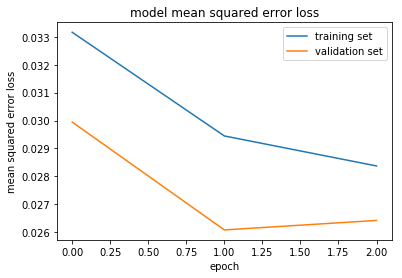

end


In [4]:

samples = []
i = 0
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if(i > 0): #this part is added to insure the 1st line in the csvfile which include the headers is not included
             samples.append(line)
        i = i + 1

        
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
print('size of original training_set= ', len(train_samples))
print('size of original validation_set= ', len(validation_samples))

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                source_path= batch_sample[0]
                filename =source_path.split(':/')[-1]
                filename =source_path.split('/')[-1]
                #print('filename after line split: ', filename)
                current_path= 'data/IMG/'+filename
                #print("center_image current_path is: ", current_path)
                center_image = cv2.imread(current_path)
                center_image = image_preprocess(center_image)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)
                images.append(cv2.flip(center_image, 1)) #flip image 180 horizontally
                angles.append(center_angle * -1.0) # reverse the steering angle
                
                
                name_left = 'data/IMG/'+batch_sample[1].split('/')[-1]
                left_image = cv2.imread(name_left)
                left_angle = center_angle + 0.2
                images.append(left_image)
                angles.append(left_angle)
                
                name_right = 'data/IMG/'+batch_sample[2].split('/')[-1]
                right_image = cv2.imread(name_right)
                right_angle = center_angle - 0.2
                images.append(right_image)
                angles.append(right_angle)
                

            # Convert to numpy float arrays.
            X_train = np.array(images)
            y_train = np.array(angles)
            # Shuffle the data for every batch
            yield sklearn.utils.shuffle(X_train, y_train)


# display sample image and it's corresponding label (steerng angle)
#print(X_train[0].shape, ' shape of train samples')
#print(" a sample of label before flipping", y_train[4823])
#print(" a sample of label after  flipping", y_train[4824])
#print("size of training set", len(X_train))            



ch, row, col = 3, 80, 320  # Trimmed image format

import keras
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense  
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Lambda
from keras.layers import Cropping2D
#from keras.utils.visualize_util import plot


model = Sequential()

# Cropping un-useful details from the image to avoid distracting model training. Here I removed 60-pixels from top and 20 pixels from bottom.
model.add(Cropping2D(cropping=((60,20), (0,0)),  input_shape = (160,320,3)))

# Preprocessing the data using Normalization and Mean-Center and using trimmed image format to perform cropping
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(80,320,3),  output_shape = (80,320,3)))


                    
# Using NVIDIA model 
model.add(Conv2D(24, (5, 5), activation="relu", strides=(2, 2)))
#model.add(MaxPooling2D())
model.add(Conv2D(36, (5, 5), activation="relu", strides=(2, 2)))
#model.add(MaxPooling2D())
model.add(Conv2D(48, (5, 5), activation="relu", strides=(2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))


# compile and train the model using the generator function
# Generate training and validation datasets and run the model in batches, where batch_size= 32
train_generator = generator(train_samples)
validation_generator = generator(validation_samples)

samples_per_epoch = len(train_samples)
batch_size = 32
steps_per_epoch = samples_per_epoch/batch_size

model.compile(loss='mse', optimizer='adam')

start = time.time()
#history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, validation_data=validation_generator,nb_val_samples=len(validation_samples), nb_epoch=3)
history = model.fit_generator(train_generator, validation_steps=len(validation_samples), steps_per_epoch=steps_per_epoch, epochs=3, validation_data=validation_generator)
print("Time fit_generator for %s samples: %s" % (len(train_samples), time.time() - start))

# save the model to reuse or download
model.save('model.h5')



### print the keys contained in the history object
print(history.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()          


# NOTE: by default Keras train for 10 epochs

# visualize model layout with pydot_ng
#plot(model, to_file='model.png', show_shapes=True)
print ('end')


## 4) This section using Nvidia  images from the thre cameras with steering correction (Not compiling sofar)

In [ ]:
import os
import time
import csv
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import sklearn
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf



samples = []
i = 0
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if(i > 0): #this part is added to insure the 1st line in the csvfile which include the headers is not included
             samples.append(line)
        i = i + 1

        
train_samples, validation_samples = train_test_split(samples, test_size=0.2)



# create adjusted steering measurements for the side camera images


#images = []
#measurments = []
# use this section if you wanna use images from the 3-cameras
#for line in lines:
    #print(line)
 #   for i in range(3):
        # get the image path from the file
  #      source_path = line[i]
   #     filename = source_path.split('/')[-1]
    #    current_path = 'IMG/'+ filename
        #print('current_path', current_path)
     #   image = cv2.imread(current_path)
      #  images.append(image)
        # get the steering measurmement (labels) from the file
       # measurment = line[3]
        #if (i == 0):
         #   measurments.append(float(measurment))
        #if (i == 1):
         #    measurments.append(float(measurment) + correction)
        #if (i == 2):
         #    measurments.append(float(measurment) - correction)
            



def generator(samples, batch_size=32):
    num_samples = len(samples)
    correction = 0.2 # this is a parameter to tune
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name_center = 'data/IMG/'+batch_sample[0].split('/')[-1]
                center_image = cv2.imread(name_center)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)
                
                name_left = 'data/IMG/'+batch_sample[1].split('/')[-1]
                left_image = cv2.imread(name_left)
                left_angle = center_angle + correction
                images.append(left_image)
                angles.append(left_angle)
                
                name_right = 'data/IMG/'+batch_sample[2].split('/')[-1]
                right_image = cv2.imread(name_right)
                right_angle = center_angle - correction
                images.append(right_image)
                angles.append(right_angle)
                

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)


# display sample image and it's corresponding label (steerng angle)
#print(X_train[0].shape, ' shape of train samples')
#print(" a sample of label before flipping", y_train[4823])
#print(" a sample of label after  flipping", y_train[4824])
#print("size of training set", len(X_train))            



ch, row, col = 3, 80, 320  # Trimmed image format

import keras
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense  
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Lambda
from keras.layers import Cropping2D
#from keras.utils.visualize_util import plot


model = Sequential()

# Preprocessing the data using Normalization and Mean-Center and using trimmed image format to perform cropping
model.add(Lambda(lambda x: (x / 127.5) - 1.0, input_shape=(160, 320, 3)))

# Cropping un-useful details from the image to avoid distracting model training. Here I removed 70-pixels from top and 25 pixels from bottom.
model.add(Cropping2D(cropping=((50,20), (0,0))))
                    
# Using NVIDIA model 
model.add(Conv2D(24, (5, 5), activation="relu", strides=(2, 2)))
#model.add(MaxPooling2D())
model.add(Conv2D(36, (5, 5), activation="relu", strides=(2, 2)))
#model.add(MaxPooling2D())
model.add(Conv2D(48, (5, 5), activation="relu", strides=(2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))


# compile and train the model using the generator function
train_generator = generator(train_samples)
validation_generator = generator(validation_samples)

samples_per_epoch = len(train_samples)
batch_size = 32
steps_per_epoch = samples_per_epoch/batch_size

model.compile(loss='mse', optimizer='adam')

start = time.time()
#history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, validation_data=validation_generator,nb_val_samples=len(validation_samples), nb_epoch=3)
history = model.fit_generator(train_generator, validation_steps=len(validation_samples), steps_per_epoch=steps_per_epoch, epochs=3, validation_data=validation_generator)
print("Time fit_generator for %s samples: %s" % (len(train_samples), time.time() - start))

# save the model to reuse or download
model.save('model.h5')



### print the keys contained in the history object
print(history.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()          


# NOTE: by default Keras train for 10 epochs

# visualize model layout with pydot_ng
#plot(model, to_file='model.png', show_shapes=True)
print ('end')


## 5) drive.py sends RGB images to the model; cv2.imread() reads images in BGR format!!!!

In [ ]:
import os
import time
import csv
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import sklearn
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf


In [ ]:
def img_conv(img):
    '''
    Method for preprocessing images: this method is the same used in drive.py, except this version uses
    BGR to YUV and drive.py uses RGB to YUV (due to using cv2 to read the image here, where drive.py images are 
    received in RGB)
    '''
    # original shape: 160x320x3, input shape for neural net: 66x200x3
    # crop to 105x320x3
    #new_img = img[35:140,:,:]
    # crop to 40x320x3
# new_img = img[50:140,:,:]
    # apply subtle blur
    new_img = cv2.GaussianBlur(img, (3,3), 0)
    # scale to 66x200x3 (same as nVidia)
#    new_img = cv2.resize(new_img,(200, 66), interpolation = cv2.INTER_AREA)
    # scale to ?x?x3
    #new_img = cv2.resize(new_img,(80, 10), interpolation = cv2.INTER_AREA)
    # convert to YUV color space (as nVidia paper suggests)
    new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2YUV)
    return new_img
print ('end')

In [ ]:
import os
import time
import csv
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import sklearn
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf



samples = []
i = 0
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if(i > 0): #this part is added to insure the 1st line in the csvfile which include the headers is not included
             samples.append(line)
        i = i + 1

        
train_samples, validation_samples = train_test_split(samples, test_size=0.2)



# create adjusted steering measurements for the side camera images


#images = []
#measurments = []
# use this section if you wanna use images from the 3-cameras
#for line in lines:
    #print(line)
 #   for i in range(3):
        # get the image path from the file
  #      source_path = line[i]
   #     filename = source_path.split('/')[-1]
    #    current_path = 'IMG/'+ filename
        #print('current_path', current_path)
     #   image = cv2.imread(current_path)
      #  images.append(image)
        # get the steering measurmement (labels) from the file
       # measurment = line[3]
        #if (i == 0):
         #   measurments.append(float(measurment))
        #if (i == 1):
         #    measurments.append(float(measurment) + correction)
        #if (i == 2):
         #    measurments.append(float(measurment) - correction)
            



def generator(samples, batch_size=32):
    num_samples = len(samples)
    correction = 0.2 # this is a parameter to tune
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name_center = 'data/IMG/'+batch_sample[0].split('/')[-1]
                center_image = cv2.imread(name_center)
                center_image = img_conv(center_image)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)
                images.append(cv2.flip(center_image, 1)) #flip image 180 horizontally
                angles.append(center_angle * -1.0) # rev
                
                name_left = 'data/IMG/'+batch_sample[1].split('/')[-1]
                left_image = cv2.imread(name_left)
                left_image = img_conv(left_image)
                left_angle = center_angle + correction
                images.append(left_image)
                angles.append(left_angle)
                
                name_right = 'data/IMG/'+batch_sample[2].split('/')[-1]
                right_image = cv2.imread(name_right)
                right_image = img_conv(right_image)
                right_angle = center_angle - correction
                images.append(right_image)
                angles.append(right_angle)
                

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)


# display sample image and it's corresponding label (steerng angle)
#print(' shape of train samples', X_train[0].shape())
#print(" a sample of label before flipping", y_train[4823])
#print(" a sample of label after  flipping", y_train[4824])
#print("size of training set", len(X_train))            



ch, row, col = 3, 80, 320  # Trimmed image format

import keras
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense  
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Lambda
from keras.layers import Cropping2D
#from keras.utils.visualize_util import plot


model = Sequential()

# Preprocessing the data using Normalization and Mean-Center and using trimmed image format to perform cropping
model.add(Lambda(lambda x: (x / 127.5) - 1.0, input_shape=( 160, 320, 3)))

# Cropping un-useful details from the image to avoid distracting model training. Here I removed 70-pixels from top and 25 pixels from bottom.
model.add(Cropping2D(cropping=((70,25), (0,0))))
                    
# Using NVIDIA model 
model.add(Conv2D(24, (5, 5), activation="relu", strides=(2, 2)))
#model.add(MaxPooling2D())
model.add(Conv2D(36, (5, 5), activation="relu", strides=(2, 2)))
#model.add(MaxPooling2D())
model.add(Conv2D(48, (5, 5), activation="relu", strides=(2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))


# compile and train the model using the generator function
train_generator = generator(train_samples)
validation_generator = generator(validation_samples)

samples_per_epoch = len(train_samples)
batch_size = 32
steps_per_epoch = samples_per_epoch/batch_size

model.compile(loss='mse', optimizer='adam')

start = time.time()
#history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, validation_data=validation_generator,nb_val_samples=len(validation_samples), nb_epoch=3)
history = model.fit_generator(train_generator, validation_steps=len(validation_samples), steps_per_epoch=steps_per_epoch, epochs=3, validation_data=validation_generator)
print("Time fit_generator for %s samples: %s" % (len(train_samples), time.time() - start))

# save the model to reuse or download
model.save('model.h5')



### print the keys contained in the history object
print(history.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()          


# NOTE: by default Keras train for 10 epochs

# visualize model layout with pydot_ng
plot(model, to_file='model.png', show_shapes=True)
print ('end')
